In [ ]:
# External package imports
import tensorflow as tf
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import the custom data loader
from data_loader import initialize_dataset

In [ ]:
# Path to data folder
data_dir = "/content/drive/MyDrive/train_tfrecords"

# Get a list of the training record files
tfrecord_files = glob.glob(os.path.join(data_dir, "*.tfrec"))

# Define the number of files for training, 70% of files
n_file_train = int(0.5 * len(tfrecord_files))

# Split the record files into 70% training and 30% validation
tfrecord_files_train = tfrecord_files[:n_file_train]
tfrecord_files_valid = tfrecord_files[n_file_train:]

In [ ]:
# Define batch size
BATCH_SIZE = 16

# Dropout rate in dropout layers
DROPOUT_RATE=0.25

# Define image crop size
CROP_SIZE = (256, 256)

# Define processed image size
IMG_SIZE = (256, 256)

In [ ]:
# Initialize the training data loader, with random flipping and rotations
dataset_train = initialize_dataset(
    tfrecord_files_train, 
    batch_size=BATCH_SIZE, 
    img_size=IMG_SIZE,
    flip=True,
    rot=(-0.25, 0.25),
    crop_size=CROP_SIZE,
    crop_random=True
)

# Initialize the validation loader, with no flipping or rotations
dataset_valid = initialize_dataset(
    tfrecord_files_valid, 
    batch_size=BATCH_SIZE, 
    img_size=IMG_SIZE,
    crop_size=CROP_SIZE
)

In [ ]:
tf.keras.backend.clear_session()

base_model = tf.keras.applications.EfficientNetB7(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(*IMG_SIZE, 3),
    pooling=None,
)

model = base_model.output

model = tf.keras.layers.GlobalAveragePooling2D()(model)

model = tf.keras.layers.Flatten()(model)
for layer_size in [1024, 1024, 1024]:
    model = tf.keras.layers.Dense(layer_size, activation="relu")(model)
    model = tf.keras.layers.Dropout(rate=DROPOUT_RATE)(model)
predictions = tf.keras.layers.Dense(5, activation = "softmax")(model)
model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

for layer in model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

In [ ]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-6),
    metrics=["accuracy"]
)

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 256, 256, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 257, 257, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    mode="max",
    patience=4,
    verbose=0,
    restore_best_weights=True
)

history = model.fit(
    x=dataset_train,
    epochs=20,
    validation_data=dataset_valid,
    callbacks=[early_stop]
)

Epoch 1/20
586/586 [==============================] - 651s 1s/step - loss: 1.2258 - accuracy: 0.5377 - val_loss: 0.7400 - val_accuracy: 0.7245
Epoch 2/20
586/586 [==============================] - 614s 1s/step - loss: 0.7374 - accuracy: 0.7300 - val_loss: 0.5990 - val_accuracy: 0.7808
Epoch 3/20
586/586 [==============================] - 613s 1s/step - loss: 0.6293 - accuracy: 0.7636 - val_loss: 0.5451 - val_accuracy: 0.8072
Epoch 4/20
586/586 [==============================] - 615s 1s/step - loss: 0.5748 - accuracy: 0.7884 - val_loss: 0.5132 - val_accuracy: 0.8199
Epoch 5/20
586/586 [==============================] - 611s 1s/step - loss: 0.5401 - accuracy: 0.8085 - val_loss: 0.4851 - val_accuracy: 0.8355
Epoch 6/20
586/586 [==============================] - 611s 1s/step - loss: 0.5110 - accuracy: 0.8175 - val_loss: 0.4732 - val_accuracy: 0.8394
Epoch 7/20
586/586 [==============================] - 613s 1s/step - loss: 0.4878 - accuracy: 0.8305 - val_loss: 0.4556 - val_accuracy: 0.8419

In [ ]:
with open('drive/MyDrive/train_history.dict', 'wb') as f:
    pickle.dump(history.history, f)

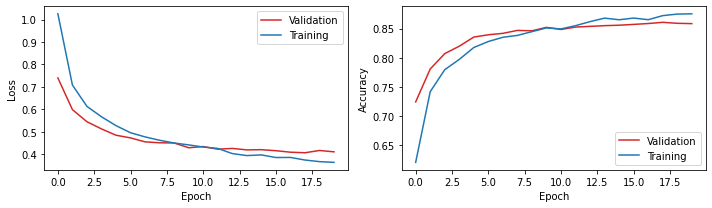

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(10,3))
axs = axs.flatten()

axs[0].plot(history.history["val_loss"], color="tab:red", label="Validation")
axs[0].plot(history.history["loss"], color="tab:blue", label="Training")
axs[0].legend()
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")

axs[1].plot(history.history["val_accuracy"], color="tab:red", label="Validation")
axs[1].plot(history.history["accuracy"], color="tab:blue", label="Training")
axs[1].legend()
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")

plt.tight_layout()
plt.savefig("drive/MyDrive/effnet_training.png", dpi=500)

In [ ]:
model.save('drive/MyDrive/EffNetB7_256x256_1024')

INFO:tensorflow:Assets written to: drive/MyDrive/EffNetB7_256x256_1024/assets


In [ ]:
model = tf.keras.models.load_model("drive/MyDrive/EffNetB7_256x256_1024")

In [ ]:
dataset_valid = initialize_dataset(
    tfrecord_files_valid, 
    batch_size=1,
)

In [ ]:
N_ENS = 50

cropper = tf.keras.layers.experimental.preprocessing.RandomCrop(*CROP_SIZE)
resizer = tf.keras.layers.experimental.preprocessing.Resizing(*IMG_SIZE)
process = tf.keras.Sequential([cropper, resizer])

y_pred = []
y = []

from tqdm import tqdm
from itertools import islice
for img, label in tqdm(dataset_valid.as_numpy_iterator()):
    y.append(label)
    imgs = tf.concat([process(img) for _ in range(N_ENS)], axis=0)
    y_ens = tf.argmax(model(imgs), axis=1)
    y_ens_unique, _, counts = tf.unique_with_counts(y_ens)
    y_pred.append(y_ens_unique[tf.argmax(counts)])

y_pred = tf.concat(y_pred, axis=0)
y = tf.concat(y, axis=0)

In [ ]:
tf.math.count_nonzero(tf.cast(y_pred, tf.int32) == y) / len(y)

<tf.Tensor: shape=(), dtype=float64, numpy=0.8715982418404564>

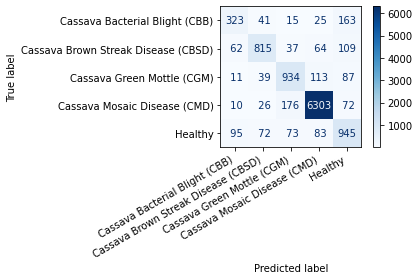

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y, y_pred)
classes = [
    "Cassava Bacterial Blight (CBB)",
    "Cassava Brown Streak Disease (CBSD)",
    "Cassava Green Mottle (CGM)",
    "Cassava Mosaic Disease (CMD)",
    "Healthy"
]
plt.figure()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
plt.gca().set_xticklabels(classes, rotation=30, ha='right', minor=False)
disp = disp.plot(cmap="Blues", xticks_rotation=30., values_format="3d", ax=plt.gca())
plt.tight_layout()
plt.savefig("drive/MyDrive/confusion.png", dpi=500)